In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from torchvision import transforms
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.models.instant_ngp import NGPModel

In [15]:
def image_to_tensor(image_path, device) -> torch.Tensor:
    # Open the image using PIL
    image = Image.open(image_path).convert("RGB")
    
    # Define the transform to convert the image to a PyTorch tensor
    transform = transforms.ToTensor()  # This will convert to a tensor with shape (C, H, W)
    
    # Apply the transform
    tensor = transform(image)  # Shape will be (3, 512, 512)
    
    # Permute the tensor to get shape (512, 512, 3)
    tensor = tensor.permute(1, 2, 0).to(device)
    
    return tensor.detach().requires_grad_(False)

def show_image(tensor):
    plt.figure(figsize=(5, 5))
    plt.imshow(tensor.detach().cpu().numpy())
    plt.axis('off')
    plt.show()

In [16]:
class iNeRFOptimizer:
    def __init__(
        self, 
        nerf_model, 
        target_image,
        initial_pose,
        dataparser_matrix,
        dataparser_scale,
        camera_params,
        lr=0.001,
        num_iterations=1000
    ):
        self.nerf_model = nerf_model
        self.device = nerf_model.device
        self.target_image = target_image.to(self.device)
        
        # Set up dataparser transforms
        self.dataparser_matrix = torch.tensor(dataparser_matrix, dtype=torch.float32, device=self.device)
        self.dataparser_scale = dataparser_scale
        
        # Set up camera parameters
        self.camera_params = camera_params
        
        # Create optimizable pose parameter - just the 3x4 part of the transformation matrix
        # We're directly optimizing the camera_to_worlds matrix here
        self.pose_param = nn.Parameter(
            torch.tensor(initial_pose, dtype=torch.float32, device=self.device)[:3, :4].clone(),
            requires_grad=True
        )
        
        # Optimizer
        self.optimizer = optim.AdamW([self.pose_param], lr=lr)
        self.num_iterations = num_iterations
        self.loss_history = []
            
    
    def optimize_step(self):
        self.optimizer.zero_grad()
        
        # We'll use finite differences to compute gradients
        eps = 1e-4  # Small epsilon for finite differences
        
        # Get current pose parameters
        pose = self.pose_param.detach().clone()
        original_loss, pred_rgb = self.compute_loss_no_grad(pose)
        
        # Compute gradients using finite differences
        grad = torch.zeros_like(pose)
        
        # For each parameter in the pose matrix
        # Note: We can optimize further by computing gradients only for 
        # parameters that are most important for alignment
        for i in range(pose.shape[0]):
            for j in range(pose.shape[1]):
                # Add epsilon to this parameter
                pose_plus = pose.clone()
                pose_plus[i, j] += eps
                
                # Compute loss with perturbed parameter
                loss_plus, _ = self.compute_loss_no_grad(pose_plus)
                
                # Compute gradient using finite difference
                grad[i, j] = (loss_plus - original_loss) / eps
        
        # Manually set gradients
        self.pose_param.grad = grad
        
        # Update parameters
        self.optimizer.step()
        
        return original_loss.item(), pred_rgb

    def compute_loss_no_grad(self, pose):
        """Compute loss without requiring gradients"""
        with torch.no_grad():
            # Create camera with the given pose
            camera = Cameras(
                camera_to_worlds=pose.unsqueeze(0),
                fx=self.camera_params["fl_x"],
                fy=self.camera_params["fl_y"],
                cx=self.camera_params["cx"],
                cy=self.camera_params["cy"],
                camera_type=CameraType.PERSPECTIVE,
                height=self.camera_params["h"],
                width=self.camera_params["w"],
            )
            
            # Get outputs using the model's built-in method for rendering
            outputs = self.nerf_model.get_outputs_for_camera(camera)
            
            # Compute loss
            pred_rgb, image = self.nerf_model.renderer_rgb.blend_background_for_loss_computation(
                pred_image=outputs["rgb"],
                pred_accumulation=outputs["accumulation"],
                gt_image=self.target_image,
            )
            
            loss = self.nerf_model.rgb_loss(image, pred_rgb)
            
        return loss, pred_rgb

    def run_optimization(self, visualize_every=50):
        best_loss = float('inf')
        best_pose = None
        best_image = None
        
        for i in range(self.num_iterations):
            loss, pred_rgb = self.optimize_step()
            self.loss_history.append(loss)
            
            if loss < best_loss:
                best_loss = loss
                best_pose = self.pose_param.detach().clone()
                best_image = pred_rgb.detach().clone()
            
            if i % visualize_every == 0 or i == self.num_iterations - 1:
                print(f"Iteration {i}, Loss: {loss:.8f}")
                print(f"Current pose:\n{self.pose_param.detach().cpu().numpy()}")
                
                if visualize_every > 0:
                    plt.figure(figsize=(15, 5))
                    
                    plt.subplot(1, 3, 1)
                    plt.imshow(self.target_image.detach().cpu().numpy())
                    plt.title("Target Image")
                    plt.axis('off')
                    
                    plt.subplot(1, 3, 2)
                    plt.imshow(pred_rgb.detach().cpu().numpy())
                    plt.title(f"Current Render (Loss: {loss:.8f})")
                    plt.axis('off')
                    
                    plt.subplot(1, 3, 3)
                    plt.plot(self.loss_history)
                    plt.title("Loss History")
                    plt.xlabel("Iteration")
                    plt.ylabel("Loss")
                    
                    plt.tight_layout()
                    plt.show()
        
        return best_pose, best_image, best_loss, self.loss_history
    
    def run_optimization(self, visualize_every=50):
        best_loss = float('inf')
        best_pose = None
        best_image = None
        
        for i in range(self.num_iterations):
            loss, pred_rgb = self.optimize_step()
            self.loss_history.append(loss)
            
            if loss < best_loss:
                best_loss = loss
                best_pose = self.pose_param.detach().clone()
                best_image = pred_rgb.detach().clone()
            
            if i % visualize_every == 0 or i == self.num_iterations - 1:
                print(f"Iteration {i}, Loss: {loss:.8f}")
                
                if visualize_every > 0:
                    plt.figure(figsize=(15, 5))
                    
                    plt.subplot(1, 3, 1)
                    plt.imshow(self.target_image.detach().cpu().numpy())
                    plt.title("Target Image")
                    plt.axis('off')
                    
                    plt.subplot(1, 3, 2)
                    plt.imshow(pred_rgb.detach().cpu().numpy())
                    plt.title(f"Current Render (Loss: {loss:.8f})")
                    plt.axis('off')
                    
                    plt.subplot(1, 3, 3)
                    plt.plot(self.loss_history)
                    plt.title("Loss History")
                    plt.xlabel("Iteration")
                    plt.ylabel("Loss")
                    
                    plt.tight_layout()
                    plt.show()
        
        return best_pose, best_image, best_loss, self.loss_history


In [17]:
# Example usage:
# 1. Load the pre-trained model
config_path = Path("/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/config.yml")
_, pipeline, _, _ = eval_setup(config_path=config_path, test_mode="inference")
nerf_model = pipeline.model
assert isinstance(nerf_model, NGPModel), "pipeline.model is not of type NGPModel"
nerf_device = nerf_model.device

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/nerfstudio_models/step-000018000.ckpt

In [18]:
# 2. Load dataparser transforms
dataparser_transforms_path = Path("/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/dataparser_transforms.json")
with open(dataparser_transforms_path, "r") as f:
    dataparser_transform = json.load(f)

dataparser_matrix = torch.tensor(dataparser_transform["transform"], dtype=torch.float32)
dataparser_matrix = np.vstack((dataparser_matrix, np.array([[0, 0, 0, 1]])))
dataparser_scale = dataparser_transform["scale"]

In [19]:
# 3. Initial camera pose (transformation matrix)
initial_pose = np.array([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424],
    [0, 0, 0, 1],
])
# Apply dataparser transform to get final initial pose
final_initial_pose = np.dot(dataparser_matrix, initial_pose)
final_initial_pose[:3, 3] = final_initial_pose[:3, 3] * dataparser_scale


In [20]:
# 4. Camera parameters
camera_params = {
    "camera_angle_x": 0.5235987755982988,
    "camera_angle_y": 0.5235987755982988,
    "fl_x": 955.4050067376327,
    "fl_y": 955.4050067376327,
    "k1": 0, "k2": 0, "k3": 0, "k4": 0, "p1": 0, "p2": 0,
    "is_fisheye": False,
    "cx": 256.0, "cy": 256.0,
    "w": 512, "h": 512,
    "aabb_scale": 32,
}


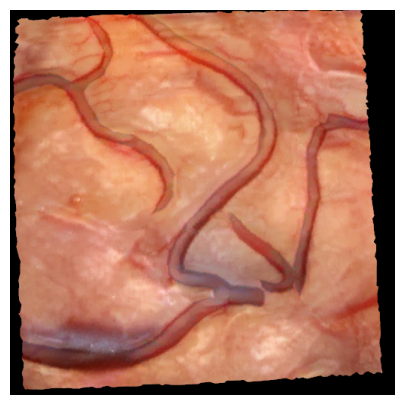

In [21]:
# 5. Load target image
target_image_path = "/n/home10/dpodolskyi/neural-registration/data/datasets/0_065_cat5_2.0/images/4.png"  # Replace with actual path
target_image = image_to_tensor(target_image_path, nerf_device)

show_image(target_image.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 0, Loss: 0.04274300


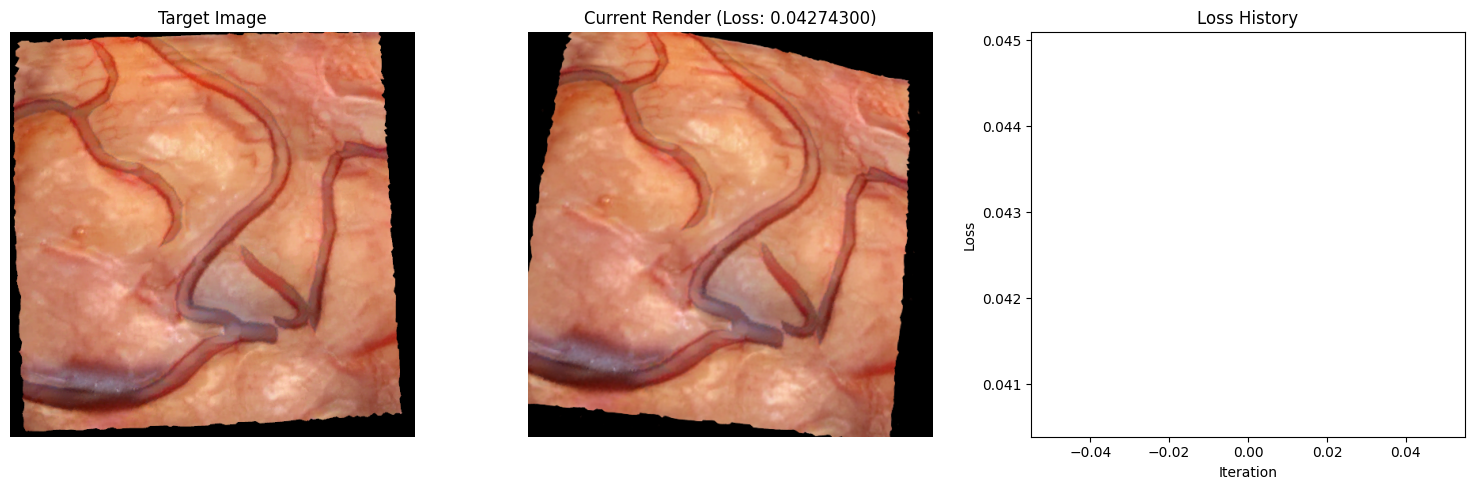

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 5, Loss: 0.03584682


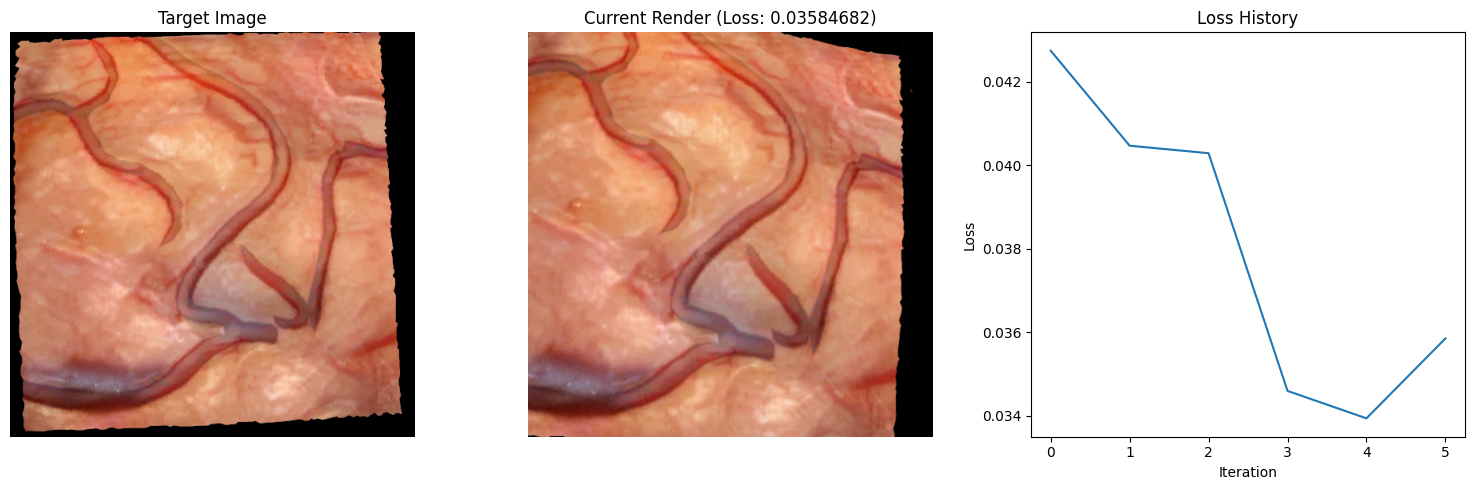

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 10, Loss: 0.02914675


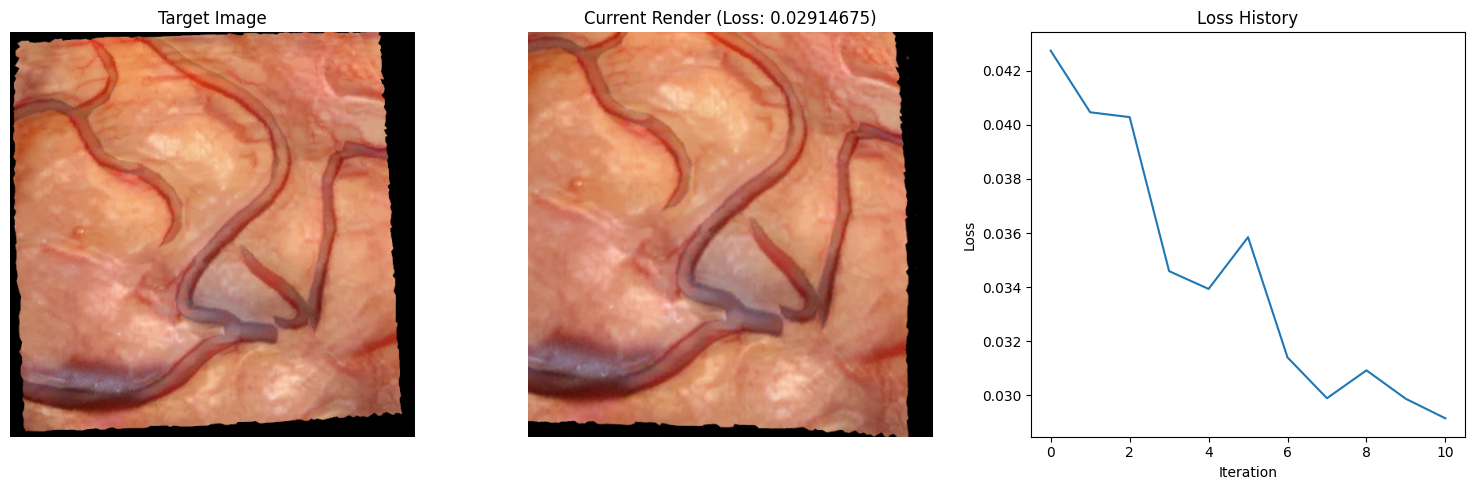

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 15, Loss: 0.02649804


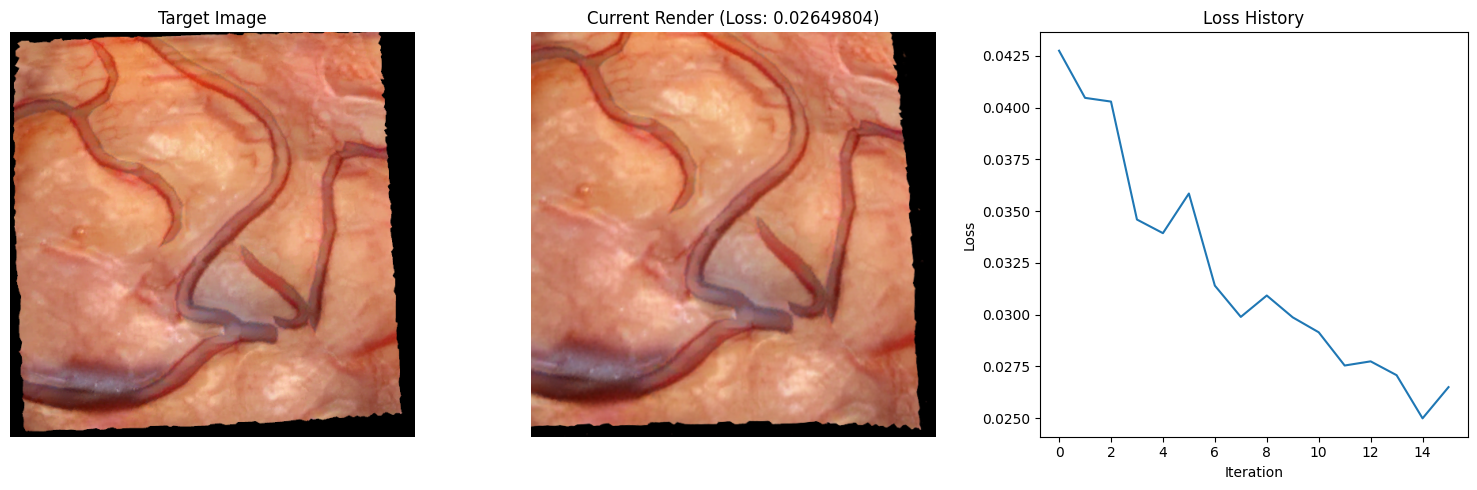

Iteration 20, Loss: 0.02271996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


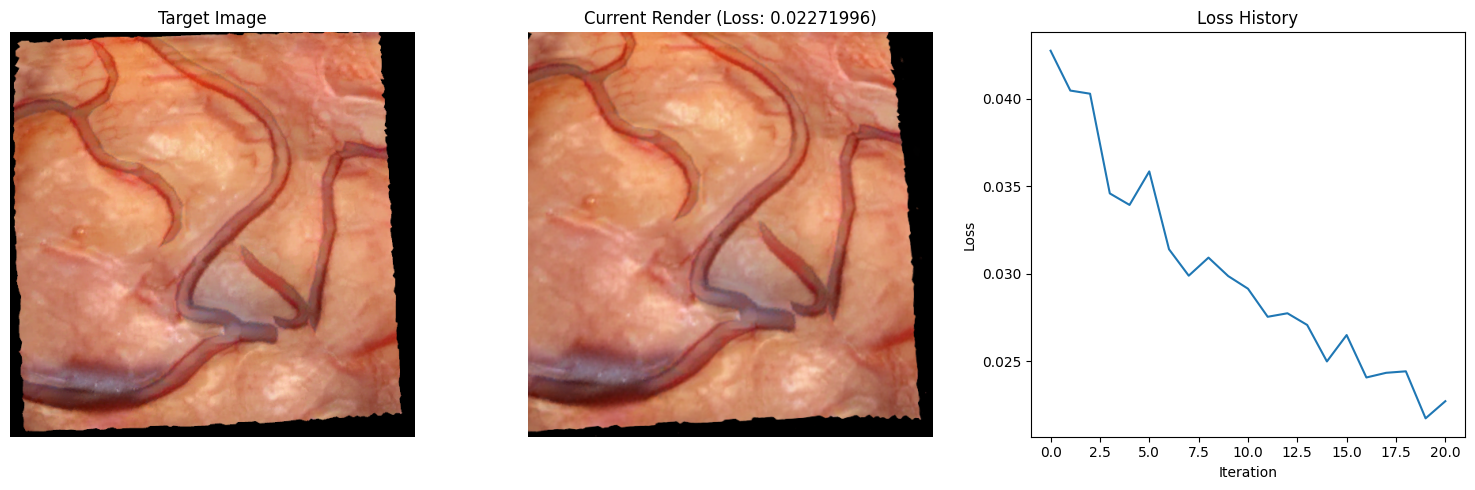

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 25, Loss: 0.01564489


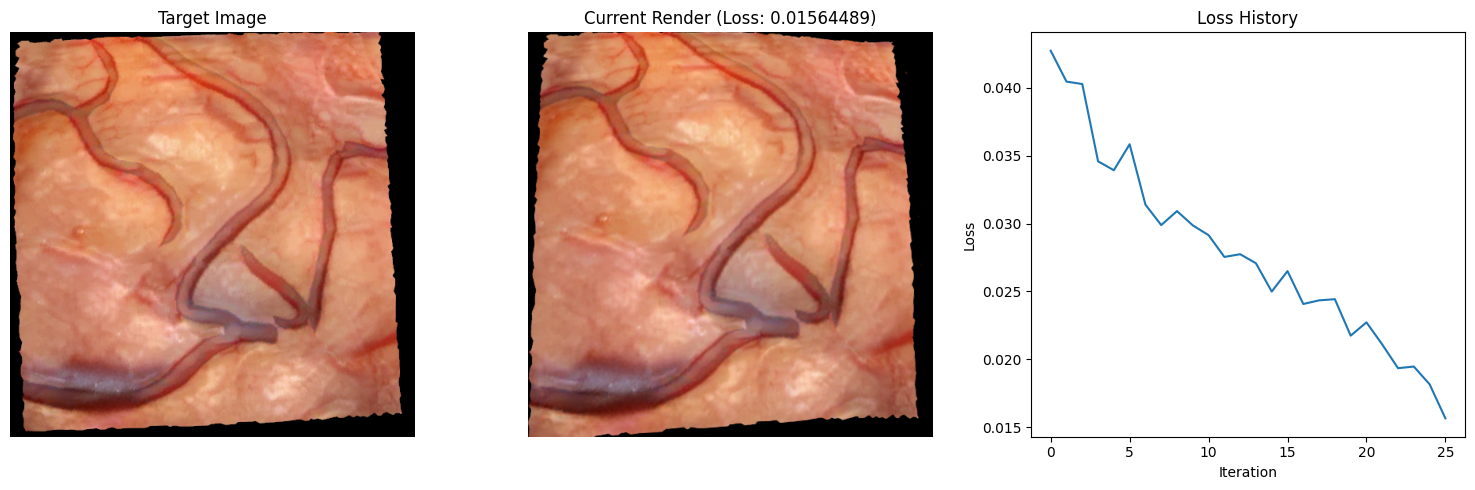

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 30, Loss: 0.01459968


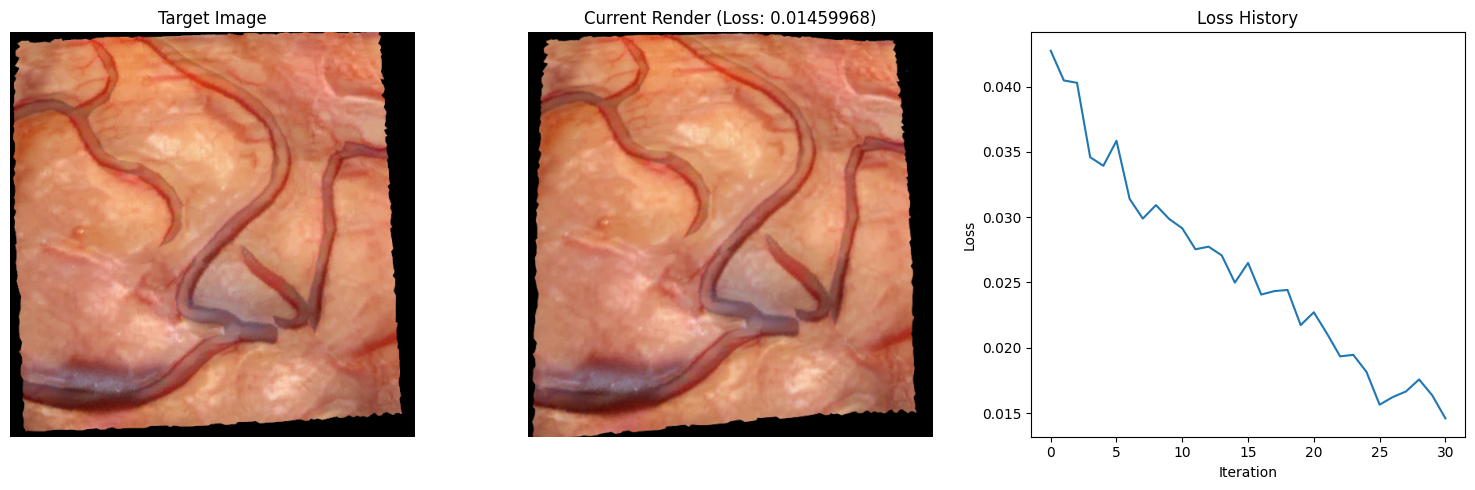

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 35, Loss: 0.01116670


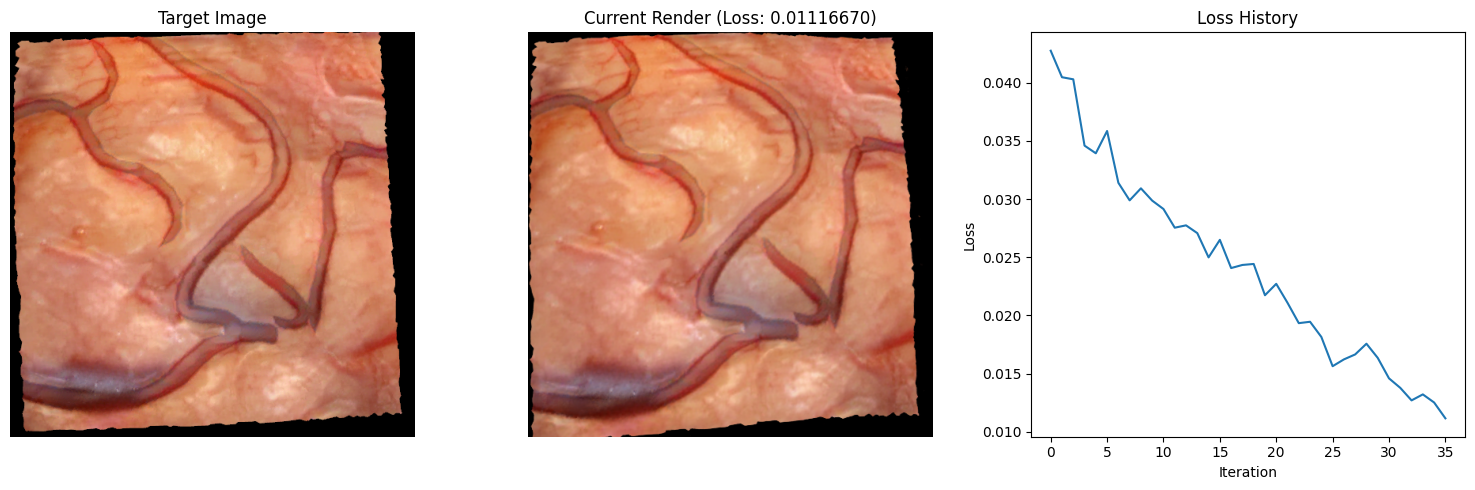

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 40, Loss: 0.00865404


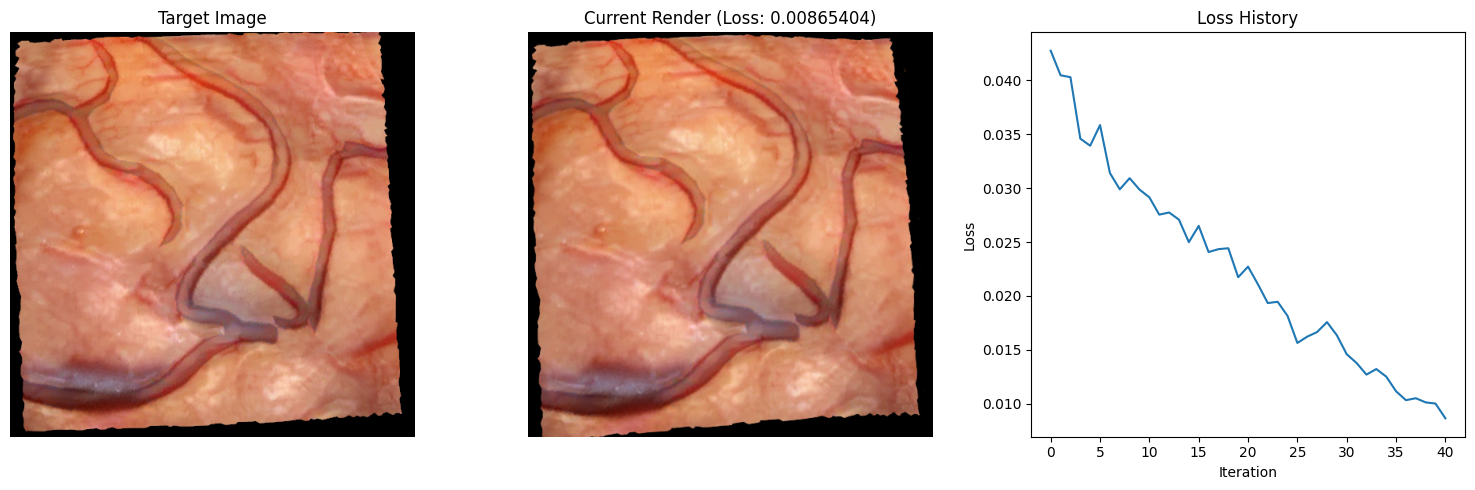

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 45, Loss: 0.00586727


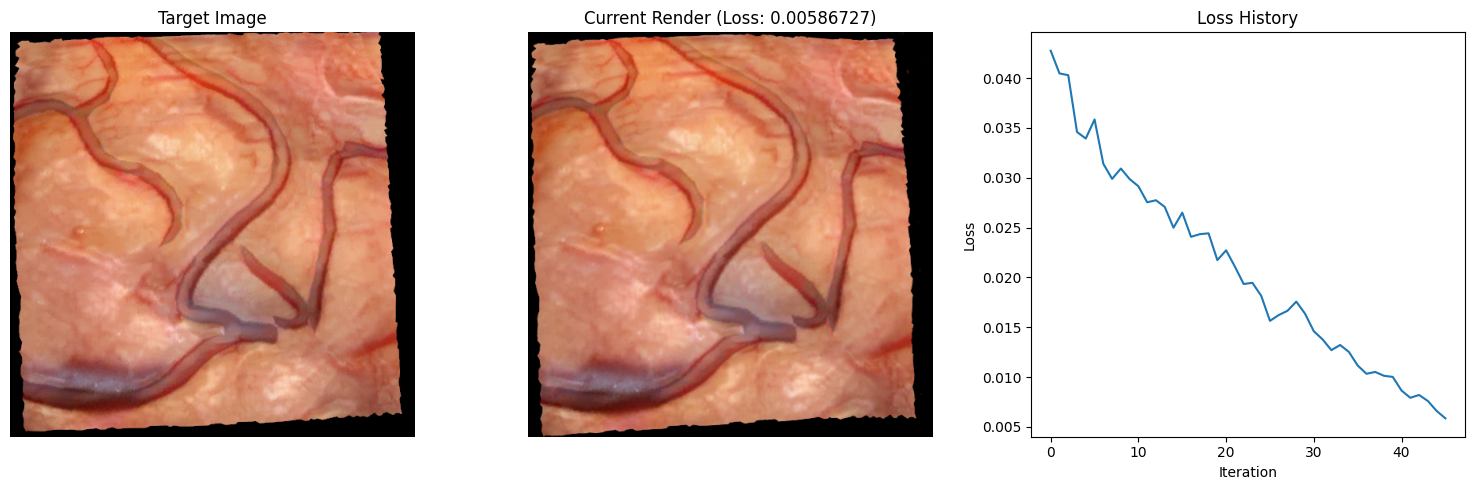

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 50, Loss: 0.00539177


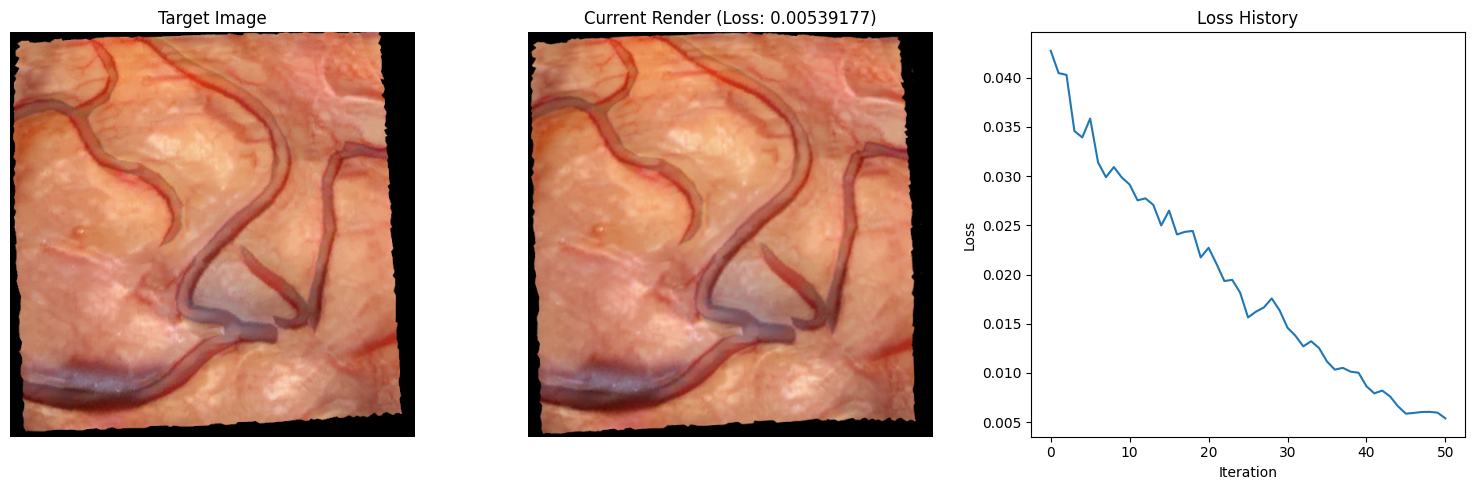

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 55, Loss: 0.00630416


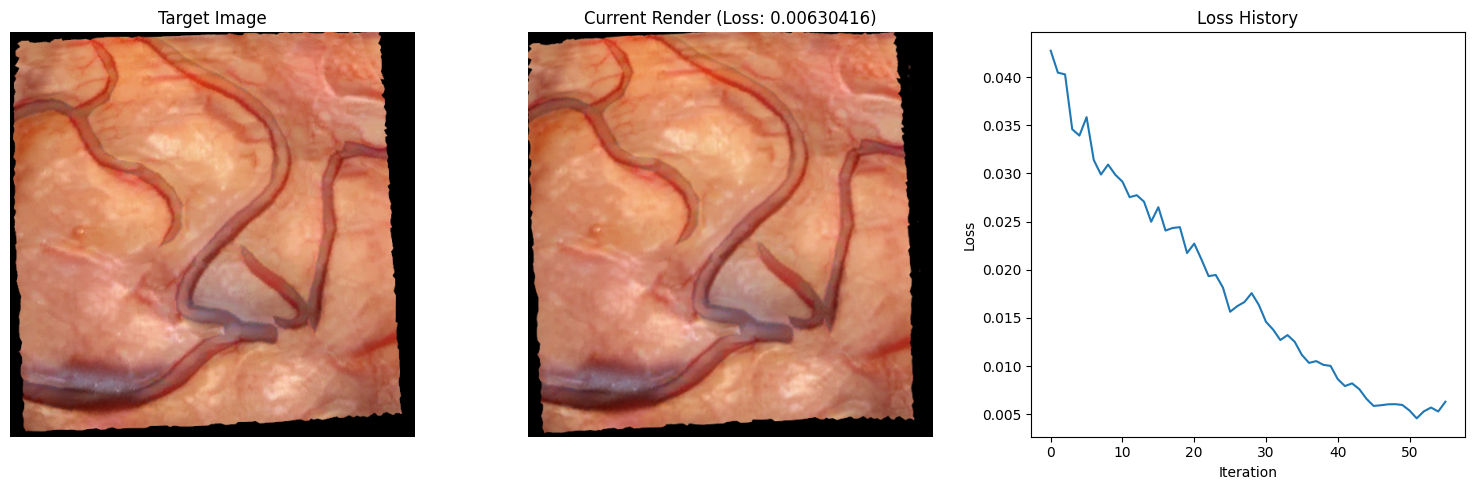

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 60, Loss: 0.00478749


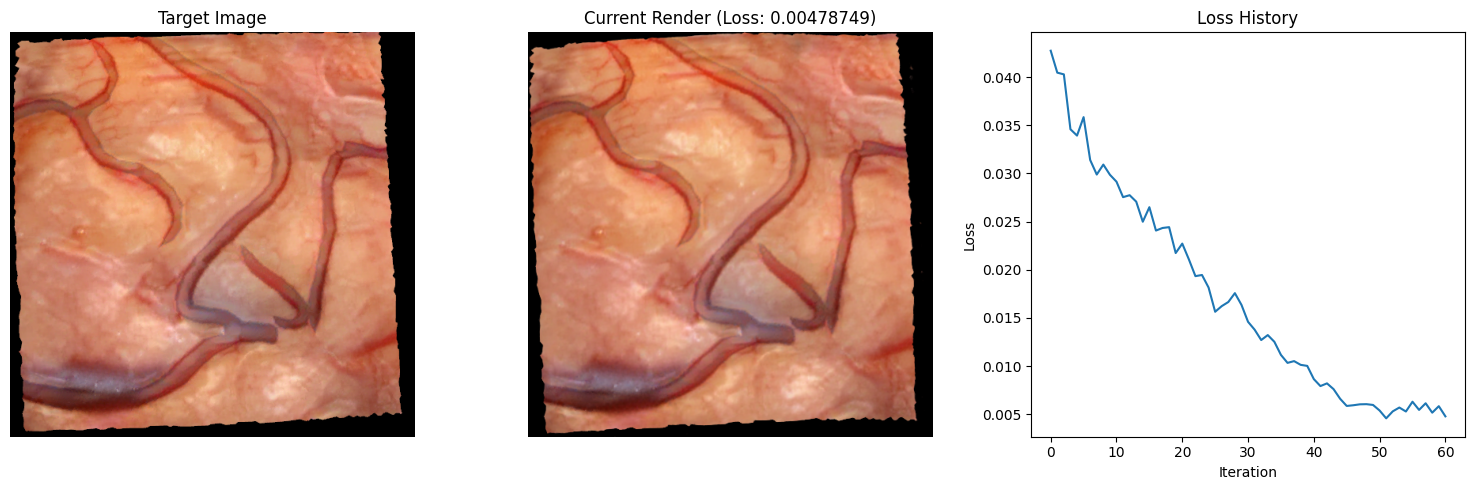

KeyboardInterrupt: 

In [24]:
# 6. Create and run the optimizer
inerf_optimizer = iNeRFOptimizer(
    nerf_model=nerf_model,
    target_image=target_image,
    initial_pose=final_initial_pose,
    dataparser_matrix=dataparser_matrix,
    dataparser_scale=dataparser_scale,
    camera_params=camera_params,
    lr=0.01,
    num_iterations=1000
)

best_pose, best_image, best_loss, loss_history = inerf_optimizer.run_optimization(visualize_every=5)


In [ ]:
# 7. Display final results
print(f"Best Loss: {best_loss:.8f}")
print("Best Pose:\n", best_pose.cpu().numpy())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(target_image.cpu().numpy())
plt.title("Target Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(best_image.cpu().numpy())
plt.title(f"Best Render (Loss: {best_loss:.8f})")
plt.axis('off')

plt.tight_layout()
plt.show()